In [81]:
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, GlobalAveragePooling2D, Activation, BatchNormalization, Dropout, Flatten, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.utils import plot_model

In [57]:
#전처리 클래스 생성
class PreprocessData:
    def __init__(self, valid_size, random_state, scaling=False):
        self.valid_size = valid_size
        self.random_state = random_state
        self.scaling = scaling
    def load_datasets(self):
        (train_images, train_labels), (test_images,test_labels) = cifar10.load_data()
        return train_images, train_labels, test_images, test_labels
    def scaled_pixels(self,images,labels):
        if self.scaling: #scaling이 True일 경우
            images = np.array(images / 255.0, dtype=np.float32)
        else:
            images = np.array(images,dtype=np.float32)
        labels = np.array(labels, dtype=np.float32)
        return images, labels
    
    def transform_ohe(self,labels):
        ohe_labels = to_categorical(labels)
        return ohe_labels
    
    def split_train_valid(self,train_images, train_ohe_labels): #훈련데이터에서 검증데이터 추출
        tr_images, val_images, tr_ohe_labels, val_ohe_labels = train_test_split(train_images,
                                                                               train_ohe_labels, test_size=self.valid_size,
                                                                               random_state = self.random_state)
        return tr_images, val_images, tr_ohe_labels, val_ohe_labels
    def preprocess_data(self):
        train_images,train_labels,test_images,test_labels = self.load_datasets()
        
        train_images, train_labels = self.scaled_pixels(train_images,train_labels)
        test_images, test_labels = self.scaled_pixels(test_images,test_labels)
        
        train_ohe_labels = self.transform_ohe(train_labels)
        test_ohe_labels = self.transform_ohe(test_labels)
        
        tr_images,  val_images, tr_ohe_labels, val_ohe_labels = self.split_train_valid(train_images,train_ohe_labels)
        
        print('Train:' ,tr_images.shape, tr_ohe_labels.shape)
        print('Valid:', val_images.shape, val_ohe_labels.shape)
        print('Test:' ,test_images.shape, test_ohe_labels.shape)
        return tr_images, tr_ohe_labels, val_images, val_ohe_labels, test_images, test_ohe_labels


In [82]:
#CNN Modeling 클래스 생성
class CnnModel:
    input_size = 32
    @classmethod
    def change_input_size(cls,input_size):
        CnnModel.input_size = input_size
    
    @staticmethod
    def create_model(verbose=True):
        size = CnnModel.input_size
        input_tensor = Input(shape=(size,size,3)) #왜 3차원인지 생각해보자   
        x = Conv2D(filters=32, kernel_size=3, padding='same', kernel_initializer='he_normal', activation='relu')(
                    input_tensor)
        x = Conv2D(filters=32, kernel_size=3, padding='same', kernel_initializer='he_normal')(x)
        x = BatchNormalization()(x)
        x = Activation('relu')(x)
        x = MaxPooling2D(pool_size=2)(x)

        x = Conv2D(filters=64, kernel_size=3, padding='same',kernel_initializer='he_normal',activation='relu')(x)
        x = Conv2D(filters=64, kernel_size=3, padding='same',kernel_initializer='he_normal')(x)
        x = BatchNormalization()(x)
        x = Activation('relu')(x)
        x = MaxPooling2D(pool_size=2)(x)

        x = Conv2D(filters=128, kernel_size=3, padding='valid', kernel_initializer='he_normal',activation='relu')(x)
        x = Conv2D(filters=128, kernel_size=3, padding='same', kernel_initializer='he_normal')(x)
        x = BatchNormalization()(x)
        x = Activation('relu')(x)
        x = MaxPooling2D(pool_size=2)(x)

        x = Conv2D(filters=256, kernel_size=3, strides=2, padding='same', kernel_initializer='he_normal')(x)
        x = BatchNormalization()(x)
        x = Activation('relu')(x)

        x = Flatten()(x)
        x = Dropout(rate=0.4)(x)
        x = Dense(units=256, kernel_initializer='he_normal', activation='relu')(x)
        x = Dropout(rate=0.3)(x)
        x = Dense(units=64, kernel_initializer='he_normal', activation='relu')(x)
        output = Dense(units=10, activation='softmax')(x)

        model = Model(inputs=input_tensor, outputs=output)

        if verbose:
            model.summary()

        return model

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 conv2d_25 (Conv2D)          (None, 32, 32, 32)        896       
                                                                 
 conv2d_26 (Conv2D)          (None, 32, 32, 32)        9248      
                                                                 
 batch_normalization_13 (Bat  (None, 32, 32, 32)       128       
 chNormalization)                                                
                                                                 
 activation_13 (Activation)  (None, 32, 32, 32)        0         
                                                                 
 max_pooling2d_11 (MaxPoolin  (None, 16, 16, 32)       0         
 g2D)                                                      

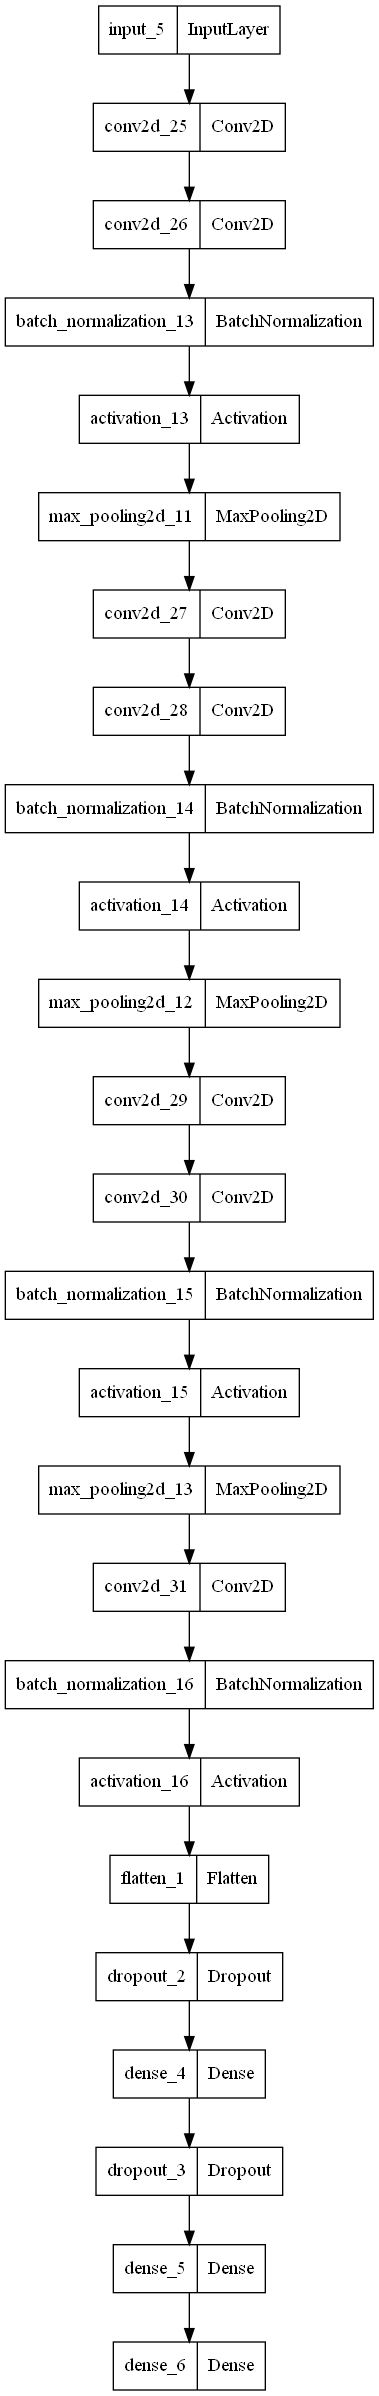

In [55]:
plot_model(CnnModel.create_model())

In [47]:
#데이터 불러오기 
data = PreprocessData(0.3, 3,scaling=True)
#data = PreprocessData(0.3, 3)
train_images, train_labels, test_images, test_labels = data.load_datasets()

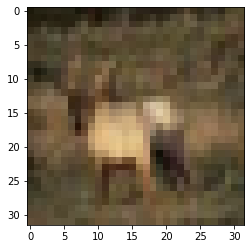

In [59]:
#train 데이터 확인
plt.imshow(train_images[3])

Original min/max: 0 255
Scaled min/max: 0.0 1.0
Original min/max: 0 255
Scaled min/max: 0.0 1.0


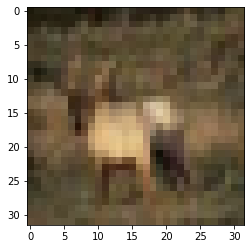

In [48]:
#train_test_images scaling
print("Original min/max:", train_images.min(), train_images.max())
train_images_scale, train_labels_scale = data.scaled_pixels(train_images, train_images)
print("Scaled min/max:", train_images_scale.min(), train_images_scale.max())
plt.imshow(train_images_scale[3])
#test_images scaling
print("Original min/max:", test_images.min(), test_images.max())
test_images_scale, test_labels_scale = data.scaled_pixels(test_images, test_images)
print("Scaled min/max:", test_images_scale.min(), test_images_scale.max())

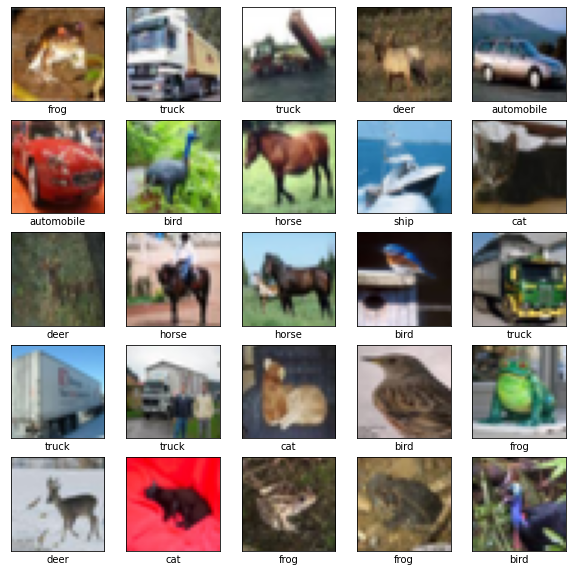

In [71]:
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer',
               'dog', 'frog', 'horse', 'ship', 'truck']

plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(train_images[i])
    # The CIFAR labels happen to be arrays, 
    # which is why you need the extra index
    plt.xlabel(class_names[train_labels[i][0]])
plt.show()

<function matplotlib.pyplot.show(close=None, block=None)>

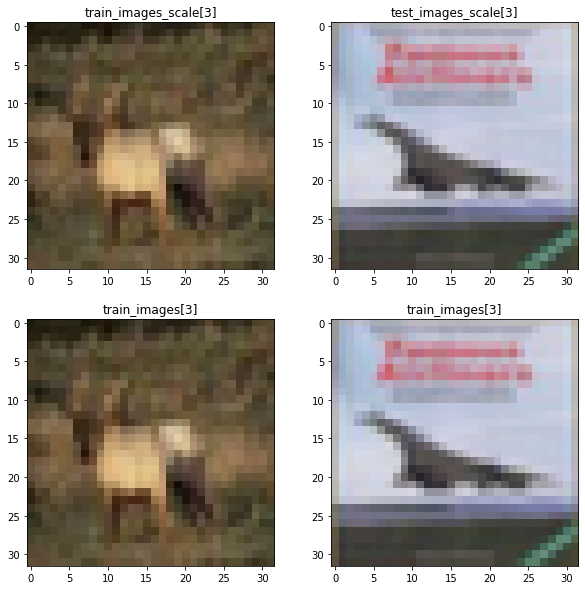

In [49]:
#SCALE before & after
plt.figure(figsize=(10,10))
plt.subplot(2,2,1)
plt.imshow(train_images_scale[3])
plt.title('train_images_scale[3]')
plt.subplot(2,2,2)
plt.imshow(test_images_scale[3])
plt.title('test_images_scale[3]')
plt.subplot(2,2,3)
plt.imshow(train_images[3])
plt.title('train_images[3]')
plt.subplot(2,2,4)
plt.imshow(test_images[3])
plt.title('train_images[3]')
plt.show

In [50]:
train_ohe_labels = data.transform_ohe(train_labels)
test_ohe_labels = data.transform_ohe(test_labels)

In [52]:
#학습/검증데이터 분할하기
tr_images, val_images, tr_ohe_labels, val_ohe_labels = data.split_train_valid(train_images_scale,train_ohe_labels)

In [58]:
#all 자동화 코드
PreprocessData(0.3,4).preprocess_data()

Train: (35000, 32, 32, 3) (35000, 10)
Valid: (15000, 32, 32, 3) (15000, 10)
Test: (10000, 32, 32, 3) (10000, 10)


(array([[[[  1.,   1.,   1.],
          [  1.,   1.,   1.],
          [  1.,   1.,   1.],
          ...,
          [114., 137., 176.],
          [ 48.,  72., 104.],
          [ 31.,  51.,  76.]],
 
         [[  1.,   1.,   1.],
          [  1.,   1.,   1.],
          [  1.,   1.,   1.],
          ...,
          [ 71.,  92., 126.],
          [ 30.,  51.,  70.],
          [  9.,  21.,  34.]],
 
         [[  1.,   1.,   1.],
          [  1.,   1.,   1.],
          [  1.,   1.,   1.],
          ...,
          [ 47.,  50.,  79.],
          [  6.,   8.,  23.],
          [  6.,  16.,  25.]],
 
         ...,
 
         [[  1.,   1.,   1.],
          [  0.,   0.,   0.],
          [ 12.,  12.,  12.],
          ...,
          [115., 131., 167.],
          [124., 138., 180.],
          [ 74.,  84., 116.]],
 
         [[  1.,   1.,   1.],
          [  1.,   1.,   1.],
          [  0.,   0.,   0.],
          ...,
          [ 41.,  50.,  68.],
          [ 97., 107., 136.],
          [ 46.,  55.,  76.

### Modeling

In [76]:
CnnModel.change_input_size(input_size=64)
print(CnnModel().input_size)

64


In [84]:
model = CnnModel.create_model()

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_9 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 conv2d_56 (Conv2D)          (None, 32, 32, 32)        896       
                                                                 
 conv2d_57 (Conv2D)          (None, 32, 32, 32)        9248      
                                                                 
 batch_normalization_32 (Bat  (None, 32, 32, 32)       128       
 chNormalization)                                                
                                                                 
 activation_32 (Activation)  (None, 32, 32, 32)        0         
                                                                 
 max_pooling2d_24 (MaxPoolin  (None, 16, 16, 32)       0         
 g2D)                                                      

In [95]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
#학습시간 문제로 epochs = 2로 설정
history = model.fit(train_images, train_labels, epochs=2, 
                    validation_data=(test_images, test_labels))

Epoch 1/2
1563/1563 [==============================] - 344s 218ms/step - loss: 0.7654 - accuracy: 0.7379 - val_loss: 0.9707 - val_accuracy: 0.6702
Epoch 2/2
1563/1563 [==============================] - 367s 235ms/step - loss: 0.6542 - accuracy: 0.7776 - val_loss: 0.7515 - val_accuracy: 0.7420


313/313 - 13s - loss: 0.7515 - accuracy: 0.7420 - 13s/epoch - 43ms/step


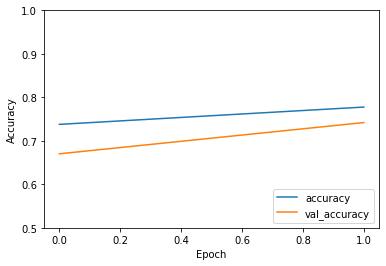

In [102]:
#Access Model
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')

test_loss, test_acc = model.evaluate(test_images,  test_labels, verbose=2)

In [103]:
print(test_acc)
print(test_loss)

0.7419999837875366
0.7515474557876587
